# **Roadmap:**
### - [Setup](#Environment-setup-for-Kubeless-functions-and-Q-learning)
### - [Training algorithm](#Train-the-agent)
### - [Result plots](#Analyze-results)

# Environment setup for Kubeless functions and DQN

## Install the gym-k8s package that registers our environments

In [ ]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas seaborn tensorflow==2.4.1 tf-agents==0.7.1

In [ ]:
import functools
import gym
import os
import subprocess
import time
import uuid
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.system import multiprocessing
from tf_agents.utils import common

from gym_k8s.envs import K8sEnvContinuousStateDiscreteActionV0

In [ ]:
multiprocessing.enable_interactive_mode()

## Info of the Kubeless app we want to deploy

In [ ]:
# Timestep duration in minutes
# We wait these many minutes for our actions to be enforced
timestep_duration = 6
app_name = 'fibonacci'
input_file = '~/serverless-elasticity-management/examples/kubeless/fibonacci-python/app.py'
handler_fun = 'app.fibonacci'
memory_req = '128Mi'
cpu_req = '80m'
sla_latency = 0.25
sla_throughput = 5
prometheus_host = 'http://localhost:9090/'
# Nginx ingress latency metric
prometheus_latency_metric_name = '(sum(rate(nginx_ingress_controller_request_duration_seconds_sum'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'\
    '/(sum(rate(nginx_ingress_controller_request_duration_seconds_count'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'.format(app_name, timestep_duration)
# Nginx ingress requests per second metric
prometheus_requests_metric_name='sum(rate(nginx_ingress_controller_requests'\
    '{{ingress="{0}"}}[{1}m])) by (ingress)'.format(app_name, timestep_duration)
# Nginx ingress denied requests per second metric
prometheus_denied_requests_metric_name='sum(rate(nginx_ingress_controller_requests'\
    '{{ingress="{0}", status!="200"}}[{1}m])) by (ingress)'.format(app_name, timestep_duration)

## Training parameters

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train_dir/')
total_epochs = 220
steps_per_epoch = 4
num_of_services = 12
total_steps_per_epoch = steps_per_epoch * num_of_services
initial_collect_epochs = 50
initial_collect_checkpoint_interval = 10
# Intervals in train steps
train_checkpoint_interval = 2
policy_checkpoint_interval = 2
rb_checkpoint_interval = 2
eval_interval = 10
eval_epochs = 1
use_tf_functions = True

## Hyperparameters

In [ ]:
learning_rate = 1e-3
gamma = 0.9
epsilon_greedy = 0.8
batch_size = 64
replay_buffer_max_length = 100000
target_update_tau = 0.05
target_update_period = 5

## Create historical states csv file if it doesn't exist

In [ ]:
try:
    open('k8s_historical_states_discrete.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('k8s_historical_states_discrete.csv', 'w') as f:
        f.write('current_timestep,action,reward,done,'
                'current_replicas,pods_backoff,pod_cpu_util,pod_memory_util,'
                'latency_violation,latency,cpu_threshold,memory_threshold,'
                'throughput_level,throughput_rate,throughput_rate_violation'
                '\n'
        )
    print('File not present. Created successfully!')

# Train the agent

Create a Kubeless environment subclass that will handle the creation, deletion and stress loading of our application:

In [ ]:
class KubelessEnv(K8sEnvContinuousStateDiscreteActionV0):
    def __init__(self,
                 timestep_duration,
                 app_name,
                 sla_latency,
                 sla_throughput,
                 prometheus_host,
                 prometheus_latency_metric_name,
                 current_requests_metric_name,
                 current_denied_requests_metric_name,
                 input_file,
                 handler_fun,
                 memory_req,
                 cpu_req,
                 max_episode_steps,
                cpu_thresh_init,
                memory_thresh_init):

        self.steps = 0
        self.vegeta_process = None
        self.max_episode_steps = max_episode_steps
        self.timestep_duration = timestep_duration
        self.input_file = input_file
        self.handler_fun = handler_fun
        self.memory_req = memory_req
        self.cpu_req = cpu_req
        service_id = uuid.uuid4()
        self.current_app_name = '{}{}'.format(app_name, service_id)
        self.endpoint = 'kubeless-{}-python.default.127.0.0.1.nip.io:8000'.format(self.current_app_name)

        current_latency_metric_name = prometheus_latency_metric_name\
            .replace(app_name, self.current_app_name)
        current_requests_metric_name = prometheus_requests_metric_name\
            .replace(app_name, self.current_app_name)
        current_denied_requests_metric_name = prometheus_denied_requests_metric_name\
            .replace(app_name, self.current_app_name)

        super().__init__(
            timestep_duration=timestep_duration,
            app_name=self.current_app_name,
            sla_latency=sla_latency,
            sla_throughput=sla_throughput,
            prometheus_host=prometheus_host,
            prometheus_latency_metric_name=current_latency_metric_name,
            prometheus_requests_metric_name=current_requests_metric_name,
            prometheus_denied_requests_metric_name=current_denied_requests_metric_name,
            cpu_thresh_init=cpu_thresh_init,
            memory_thresh_init=memory_thresh_init
        )

    def step(self, action):
        if self.vegeta_process is not None:
            self.vegeta_process.kill()
            self.vegeta_process = None
        self._stress_function()

        ret_value = super().step(action)

        self.steps += 1
        if self.steps % self.max_episode_steps == 0:
            self.steps = 0

        return ret_value

    def reset(self):
        self.steps = 0
        # Delete existing service
        self.cleanup()
        time.sleep(2 * 60)

        # Deploy new one
        self._deploy_service()

        # Wait long enough so that the pods are ready before
        # the ingress object and the HPA are created
        time.sleep(60)
        # Create ingress object
        self._create_ingress()

        return super().reset()

    def close(self):
        self.cleanup()

    def cleanup(self):
        if self.vegeta_process is not None:
            self.vegeta_process.kill()
            self.vegeta_process = None
        self._delete_service()

    def _deploy_service(self):
        """This function deploys a new Kubeless function"""
        deploy_args = {
            'service_name': self.current_app_name,
            'input_file': self.input_file,
            'handler_fun': self.handler_fun,
            'memory_req': self.memory_req,
            'cpu_req': self.cpu_req
        }

        msg = subprocess.getoutput('kubeless function deploy {service_name} --runtime python3.7 '
                                   '--from-file {input_file} '
                                   '--handler {handler_fun} '
                                   '--label service-name={service_name} '
                                   '--memory {memory_req} '
                                   '--cpu {cpu_req}'.format(**deploy_args))
        print(msg)

    def _create_ingress(self):
        """This function creates a new ingres object"""
        ingress_create_args = {
            'service_name': self.current_app_name,
            'hostname': 'kubeless-{}-python.default.127.0.0.1.nip.io'.format(self.current_app_name)
        }

        msg = subprocess.getoutput('kubeless trigger http create {service_name} '
                                   '--function-name {service_name} '
                                   '--hostname {hostname}'.format(**ingress_create_args))
        print(msg)

    def _stress_function(self):
        """Stress functions
        We use a vegeta script to stress our application
        """
        rate_per_second = 0.5
        rate_per_minute = int(rate_per_second * 60)

        self.vegeta_process = subprocess.Popen('stress-test/vegeta-stress.sh {} {} {} {}'
                       .format(self.endpoint, rate_per_minute, self.timestep_duration, self.steps), shell=True)

    def _delete_service(self):
        """Function cleanup
        This function deletes our Kubeless functions. The ingress objects and the HPAs are also deleted
        """
        msg = subprocess.getoutput('kubeless function delete {}'.format(self.current_app_name))
        print(msg)

Create callable function to pass to the ParallelPyEnvironment constructor:

In [ ]:
def create_py_env(cpu_thresh_init=None, memory_thresh_init=None):
    env = KubelessEnv(
        timestep_duration,
        app_name,
        sla_latency,
        sla_throughput,
        prometheus_host,
        prometheus_latency_metric_name,
        prometheus_requests_metric_name,
        prometheus_denied_requests_metric_name,
        input_file,
        handler_fun,
        memory_req,
        cpu_req,
        steps_per_epoch,
        cpu_thresh_init,
        memory_thresh_init
    )
    py_env = suite_gym.wrap_env(env)
    return py_env

## Agent training
The global step variable tracks how many times we've run our train function on the agent:

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step()

Create `num_of_services` parallel environments for training. The batch size for the underlying PyEnvironment becomes equal to `num_of_services`. For example for 15 services, the environment takes one action for each and treats all 15 actions as a batch. We use this batch size when we instantiate our replay buffer:

In [ ]:
train_py_env = parallel_py_environment.ParallelPyEnvironment([create_py_env] * num_of_services)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

# 5 parallel evaluation environments
eval_env_constructors = [functools.partial(create_py_env, cpu_thresh_init=thresh, memory_thresh_init=thresh) for thresh in range(20, 100 + 1, 20)]
eval_envs_num = len(eval_env_constructors)
eval_py_env = parallel_py_environment.ParallelPyEnvironment(eval_env_constructors)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Environment information:

In [ ]:
print('action_spec:', train_env.action_spec())
print('time_step_spec.observation:', train_env.time_step_spec().observation)
print('time_step_spec.step_type:', train_env.time_step_spec().step_type)
print('time_step_spec.discount:', train_env.time_step_spec().discount)
print('time_step_spec.reward:', train_env.time_step_spec().reward)

Create Q Network and DQN Agent:

In [ ]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,)
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=epsilon_greedy,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    gamma=gamma
)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

Create a replay buffer where we collect training data:

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

Create a driver that runs a total of `num_steps` in our train env each time we call its `run` function:

In [ ]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=total_steps_per_epoch
)

Create checkpointers that will periodically save our agent, policy and replay buffer to disk:

In [ ]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    agent=agent,
    global_step=global_step
)

policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'policy'),
    policy=eval_policy,
    global_step=global_step
)

rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=replay_buffer
)

train_checkpointer.initialize_or_restore()
rb_checkpointer.initialize_or_restore();

Collect initial buffer experience:

In [ ]:
initial_collect_step = tf.Variable(0, trainable=False)

initial_collect_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'initial_collect'),
    initial_collect_step=initial_collect_step
)

initial_collect_checkpointer.initialize_or_restore()

initial_collect_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=total_steps_per_epoch
)

if use_tf_functions:
    initial_collect_driver.run = common.function(initial_collect_driver.run)

while True:
    print('Collect step: {}'.format(initial_collect_step.numpy()))

    if initial_collect_step.numpy() == initial_collect_epochs:
        break

    initial_collect_driver.run()
    initial_collect_step = tf.add(initial_collect_step, 1)

    if initial_collect_step.numpy() % initial_collect_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=initial_collect_step.numpy())
        initial_collect_checkpointer.save(global_step=initial_collect_step.numpy())

In [ ]:
if use_tf_functions:
    # To speed up collect use common.function.
    collect_driver.run = common.function(collect_driver.run)
    agent.train = common.function(agent.train)

time_step = None
policy_state = collect_policy.get_initial_state(train_env.batch_size)

# If num_steps is not set, the dataset returns states and not transitions
# from state to state. So we set it to equal 2 aka a transition from one state to another
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

def train_step():
    experience, _ = next(iterator)
    return agent.train(experience)

if use_tf_functions:
    train_step = common.function(train_step)

Training loop:

In [ ]:
while True:
    print('Global step: {}'.format(global_step.numpy()))
    if global_step.numpy() == total_epochs:
        break

    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state
    )
    train_loss = train_step()

    if global_step.numpy() % train_checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % policy_checkpoint_interval == 0:
        policy_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % eval_interval == 0:
        eval_time_step = eval_env.reset()

        for epoch in range(eval_epochs):
            for step in range(steps_per_epoch):
                action_step = eval_policy.action(eval_time_step)

                eval_time_step = eval_env.step(action_step.action)

                # Get results for each of our parallel evaluation environments
                for env in range(eval_envs_num):
                    reward = eval_time_step.reward.numpy()[env]
                    observation = eval_time_step.observation.numpy()[env]
                    done = eval_env.pyenv.envs[env].done

                    (pod_cpu_util,
                     cpu_threshold,
                     pod_memory_util,
                     memory_threshold,
                     current_replicas,
                     pods_backoff,
                     latency,
                     throughput_level,
                     throughput_rate) = observation

                    # Latency violation becomes 1 if the SLA was violated otherwise it's 0
                    latency_violation = int(latency > sla_latency)
                    throughput_rate_violation = int(throughput_rate < 0.95)

                    # Offset the eval epoch by 1 because the first evaluation takes place at the 10th global step
                    current_eval_epoch = (global_step.numpy() // eval_interval) -1
                    current_step = (current_eval_epoch * eval_epochs + epoch) * steps_per_epoch + step

                    action = action_step.action.numpy()[env]

                    # Save historical tuple
                    with open('k8s_historical_states_discrete.csv', 'a') as f:
                        f.write(
                            '{},{},{},{},'.format(current_step, action, reward, done) +
                            '{},{},{},{},'.format(current_replicas, pods_backoff, pod_cpu_util, pod_memory_util) +
                            '{},{},{},{},'.format(latency_violation, latency, cpu_threshold, memory_threshold) +
                            '{},{},{}'.format(throughput_level, throughput_rate, throughput_rate_violation) +
                            '\n'
                        )

## Cleanup

In [ ]:
train_env.close()
eval_env.close()

# Analyze results

- [Resources diagram per epoch](#Resources-diagram-per-epoch)
- [Resources diagram per timestep](#Resources-diagram-per-timestep)
- [Resources diagram per stress phase](#Resources-diagram-per-stress-phase)

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('whitegrid')

data = pd.read_csv('old-outputs/01/k8s_historical_states_discrete.csv')

Convert timesteps to epochs:

In [2]:
data_copy = data.copy()

steps_per_eval = 4
evaluation_epochs = 5
data['current_timestep'] = data['current_timestep'].floordiv(steps_per_eval * evaluation_epochs)
epoch_grouped_data = data.groupby(['current_timestep'], as_index=False)

Average results:

In [3]:
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()

## Resources diagram per epoch

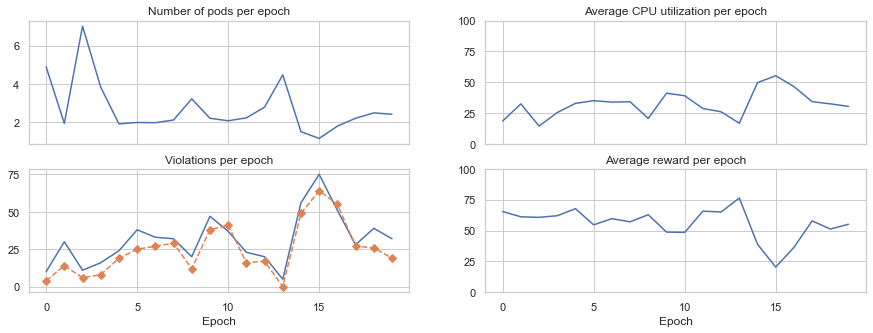

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

ax = axs[0, 0]
epoch_data_mean.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, title='Number of pods per epoch', legend=None)
ax.set_xlabel('Epoch')

ax = axs[0, 1]
ax.set_ylim(0, 100)
epoch_data_mean.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, title='Average CPU utilization per epoch', legend=None)
ax.set_xlabel('Epoch')

ax = axs[1, 0]
epoch_data_sum.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, title='Violations per epoch')
epoch_data_sum.plot(kind='line', x='current_timestep', y='throughput_rate_violation', ax=ax, style='D--')
ax.legend(['Latency violations', 'Success ratio violations'])
ax.set_xlabel('Epoch')

ax = axs[1, 1]
ax.set_ylim(0, 100)
epoch_data_mean.plot(kind='line', x='current_timestep', y='reward', ax=ax, title='Average reward per epoch', legend=None)
ax.set_xlabel('Epoch')

plt.xticks(range(
    epoch_data_mean['current_timestep'].min(),
    epoch_data_mean['current_timestep'].max() + 1
))

for ax_array in axs:
    for ax in ax_array:
        ax.set_xlabel('Epoch')
        ax.legend().set_visible(False)
        ax.locator_params(tight=True, nbins=4)

plt.show()

## Resources diagram per timestep

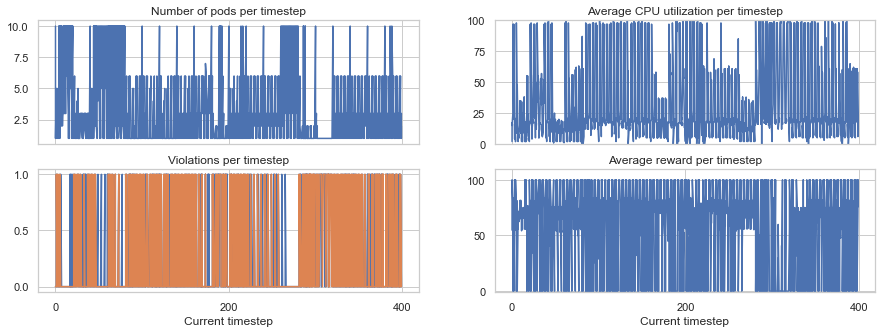

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

ax = axs[0, 0]
data_copy.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, title='Number of pods per timestep', legend=None)

ax = axs[0, 1]
ax.set_ylim(0, 100)
data_copy.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, title='Average CPU utilization per timestep', legend=None)

ax = axs[1, 0]
data_copy.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, title='Violations per timestep')
data_copy.plot(kind='line', x='current_timestep', y='throughput_rate_violation', ax=ax)
ax.legend(['Latency violations', 'Success ratio violations'])

ax = axs[1, 1]
ax.set_ylim(-1, 110)
data_copy.plot(kind='line', x='current_timestep', y='reward', ax=ax, title='Average reward per timestep', legend=None)

for ax_array in axs:
    for ax in ax_array:
        ax.set_xlabel('Current timestep')
        ax.legend().set_visible(False)
        ax.locator_params(tight=True, nbins=4)

plt.show()

## Resources diagram per stress phase

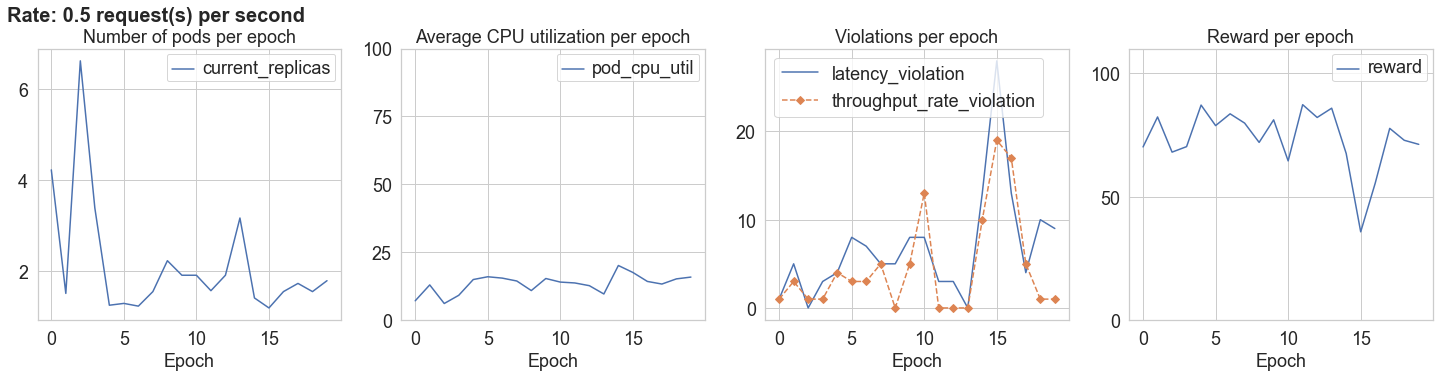

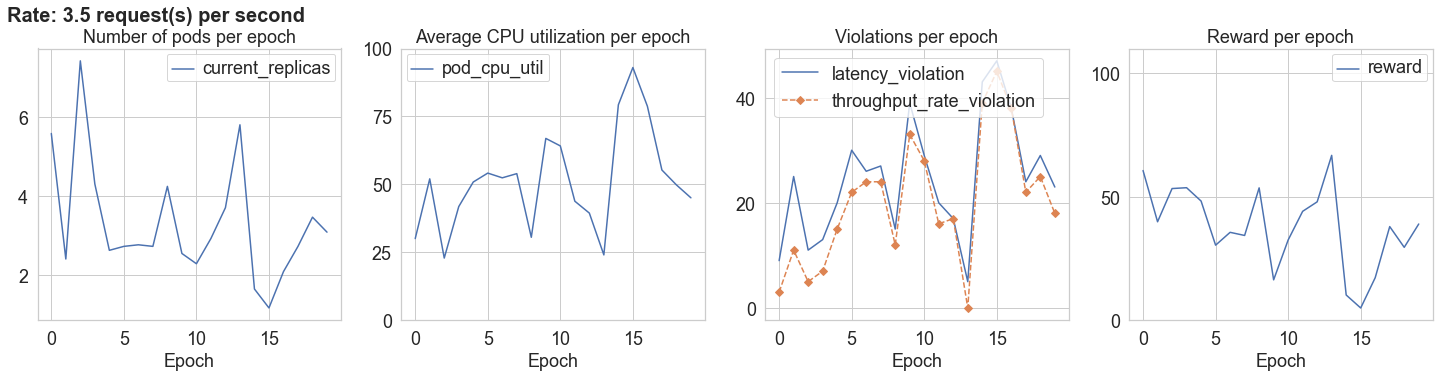

In [32]:
steps_per_epoch = 4
evaluation_epochs = 5
rate_per_second = 0.5
# Rate-Timesteps dictionary
rates_timesteps_dict = {
    rate_per_second: [0, 3],
    7 * rate_per_second: [1, 2]
}

for rate in rates_timesteps_dict:
    local_copy = data_copy[data_copy.current_timestep.mod(steps_per_epoch).isin(rates_timesteps_dict[rate])].copy()
    local_copy['current_timestep'] = local_copy['current_timestep'].floordiv(steps_per_epoch * evaluation_epochs)
    local_copy_grouped = local_copy.groupby(['current_timestep'], as_index=False)
    local_copy_mean = local_copy_grouped.mean()
    local_copy_sum = local_copy_grouped.sum()

    fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharex=True)

    ax = axs[0]
    local_copy_mean.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, title='Number of pods per epoch', legend=None)
    annotation = 'Rate: {} request(s) per second'.format(rate)
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, 
            size=20, weight='bold')

    ax = axs[1]
    ax.set_ylim(0, 100)
    local_copy_mean.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, title='Average CPU utilization per epoch', legend=None)

    ax = axs[2]
    local_copy_sum.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, title='Violations per epoch')
    local_copy_sum.plot(kind='line', x='current_timestep', y='throughput_rate_violation', ax=ax, style='D--')
    ax.legend(['Latency violations', 'Success ratio violations'], loc='upper left')

    ax = axs[3]
    ax.set_ylim(0, 110)
    local_copy_mean.plot(kind='line', x='current_timestep', y='reward', ax=ax, title='Reward per epoch', legend=None)

    plt.xticks(range(
        local_copy_mean['current_timestep'].min(),
        local_copy_mean['current_timestep'].max() + 1,
        1
    ))
    
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.locator_params(tight=True, nbins=4)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()) + ax.legend().get_texts():
            item.set_fontsize(18)

    axs[2].legend(loc='upper left', prop={'size': 18})

    plt.show()